In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.table import Table, Column, vstack, join

In [27]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [15]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

- Pre-defined number density bins

In [7]:
topn_bins = Table.read(os.path.join(bin_dir, "topn_bins.fits"))

- Redshift limits and the survey volumes

In [10]:
# Redshift limits and survey volume
z_low, z_upp = 0.19, 0.52

s16a_vol = utils.get_volume(hsc.A_S16A, z_low, z_upp)
s16a_vol_mpdl2 = utils.get_volume(hsc.A_S16A, z_low, z_upp, h=0.6777)

# Volume between 0.19 < z < 0.52 is 97824323.66826256 Mpc^3
# Volume between 0.19 < z < 0.52 is 107802421.71232714 Mpc^3


### Prepare the data

#### redMaPPer HSC catalog

- Need the redMaPPer and massive galaxies catalogs from the pre-compute data

In [16]:
# Pre-compute
s16a_precompute = os.path.join(data_dir, 'topn_public_s16a_medium_precompute.hdf5')

topn_cluster = pickle.load(open(os.path.join(res_dir, 'topn_clusters_cen_sum.pkl'), 'rb'))

redm_hsc_pre = Table.read(s16a_precompute, 'redm_hsc')
redm_hsc_result = topn_cluster['redm_hsc_lambda']

redm_hsc_pre.sort('lambda')
redm_hsc_pre.reverse()

In [17]:
# For redMaPPer richness function
loglam = np.log(redm_hsc_pre['lambda'])

lam_low, lam_upp, lam_nbin = np.log(5.), np.log(135.0), 8

lam_smf = utils.mass_function_list(
    loglam, s16a_vol, lam_nbin, lam_low, lam_upp, scatter=0.0, nsample=500)

lam_bin = np.linspace(lam_low, lam_upp, lam_nbin + 1)
lam_cen = (lam_bin[1:] + lam_bin[0:-1]) / 2

lam_phi_avg = np.nanmedian(lam_smf, axis=0)
lam_phi_low = np.percentile(lam_smf, 16, axis=0)
lam_phi_upp = np.percentile(lam_smf, 84, axis=0)

lam_inter = interpolate.interp1d(
    lam_cen, np.log10(lam_phi_avg), fill_value='extrapolate', kind='linear')

In [18]:
lam_bound = list(np.round(redm_hsc_pre['lambda'][redm_hsc_result['index_low']], 1))
lam_bound.append(np.round(redm_hsc_pre['lambda'][redm_hsc_result['index_upp']][-1], 1))

loglam_bound = np.log(lam_bound)

phi_lam = lam_inter(loglam_bound)

#### HSC Massive Galaxies

In [28]:
hsc_massive = Table.read(s16a_precompute, 'hsc')

cen_mask = (hsc_massive['cen_mask_1'] > 0)
mask_mod = (hsc_massive['logm_max'] >= 11.0) & cen_mask

ranks_low, ranks_upp = redm_hsc_result['index_low'] + 1, redm_hsc_result['index_upp'] + 1

mmax_masks = catalog.get_mask_list(
    hsc_massive['logm_100'], ranks_low, ranks_upp, master_mask=cen_mask)

catalog.add_outer_mass(hsc_massive, 'logm_50', 'logm_100')

mout_masks = catalog.get_mask_list(
    hsc_massive['logm_50_100'], ranks_low, ranks_upp, master_mask=cen_mask)

#### MDPL2 halo mass function

- MDPL2 halo mass function has been pre-computed

In [19]:
mdpl2_hmf = Table.read(os.path.join(sim_dir, 'mdpl2_hmf.fits'))

mdpl_cen = mdpl2_hmf['log_mh'][:-1]
mdpl_phi_low, mdpl_phi_upp = mdpl2_hmf['phi_low'][:-1], mdpl2_hmf['phi_upp'][:-1]
mdpl_phi_avg = mdpl2_hmf['phi'][:-1]

mdpl_inter = interpolate.interp1d(
    mdpl_cen, np.log10(mdpl_phi_avg), fill_value='extrapolate', kind='linear')

In [21]:
# Halo mass distribution from MDPL2
mdpl2_halo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

logmh_bound = np.around(
    [mdpl2_halo[mdpl2_halo['scatter'] == 0.0][0]['edge'].max(),
     mdpl2_halo[mdpl2_halo['scatter'] == 0.0][0]['edge'].min(),
     mdpl2_halo[mdpl2_halo['scatter'] == 0.0][1]['edge'].min(),
     mdpl2_halo[mdpl2_halo['scatter'] == 0.0][2]['edge'].min(),
     mdpl2_halo[mdpl2_halo['scatter'] == 0.0][3]['edge'].min()], 2)

phi_mdpl = mdpl_inter(logmh_bound)

### Making the Figure

In [22]:
marker_bins = ['o', 's', 'h', '8', '+']
msize_bins = [100, 100, 130, 110, 150]
color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]
label_bins = [r'$\rm Bin\ 1$', r'$\rm Bin\ 2$', r'$\rm Bin\ 3$', r'$\rm Bin\ 4$']

# 21641/27207 objects are shown on the figure


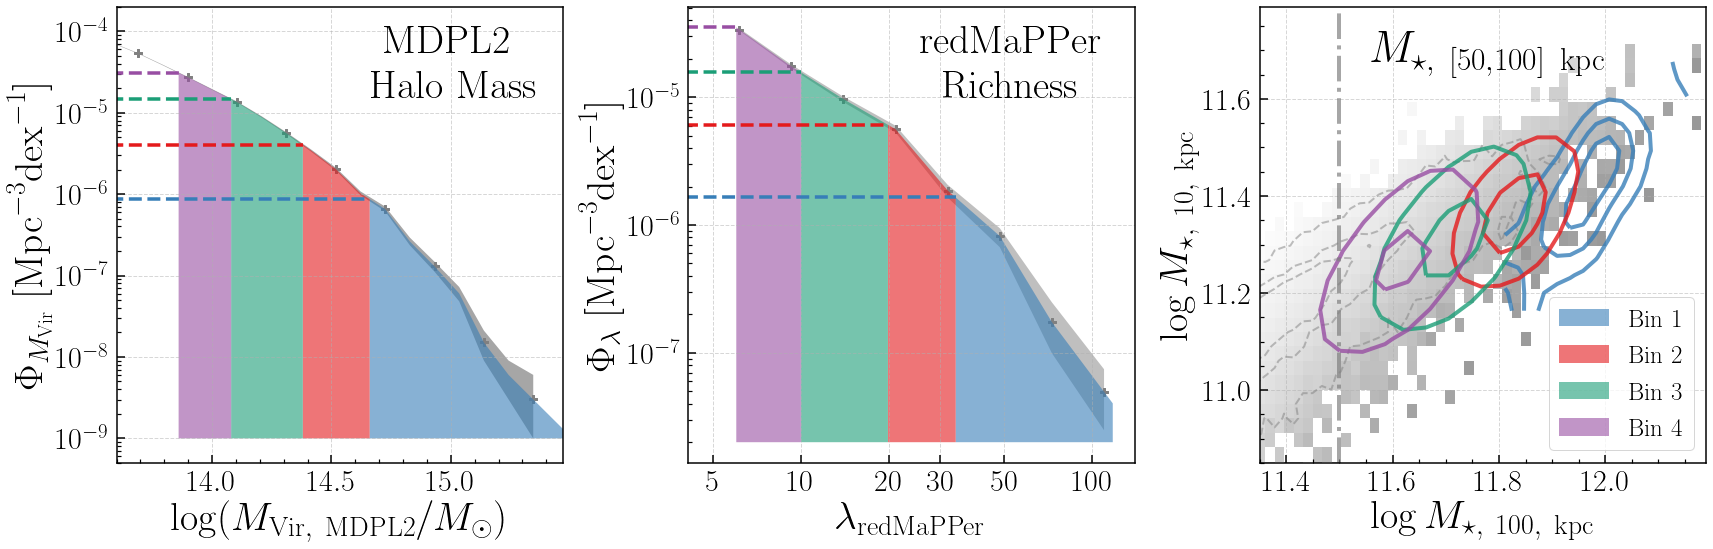

In [29]:
fig = plt.figure(figsize=(24, 7.5))
fig.subplots_adjust(left=0.07, right=0.99, bottom=0.15, top=0.995,
                    wspace=0.28, hspace=0.20)

# --------------------------- #
# MDPL2 Halo mass function

ax1 = fig.add_subplot(131)
ax1.set_yscale("log", nonpositive='clip')

ax1.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# HMF

mdpl_phi_low[-1] = 1e-9
ax1.fill_between(mdpl_cen, mdpl_phi_low, mdpl_phi_upp, alpha=0.7, facecolor='grey', 
                 label=r'__no_label', zorder=0)
ax1.scatter(mdpl_cen[::2], mdpl_phi_avg[::2], marker='P', c='grey', s=50, label='__no_label')


# Bin 1
mdpl_bin1 = np.linspace(logmh_bound[1], logmh_bound[0], 1500)
ax1.fill_between(mdpl_bin1, mdpl_bin1 * 0 + 1e-9, 10.0 ** mdpl_inter(mdpl_bin1), 
                 alpha=0.6, facecolor=color_bins[0], label=r'$\rm Bin\ 1$', rasterized=True)

ax1.plot(np.asarray([12.30, logmh_bound[1]]), 
         np.asarray([10.0 ** phi_mdpl[1], 10.0 ** phi_mdpl[1]]), 
         linewidth=3.5, linestyle='--', color=color_bins[0])

# Bin 2
mdpl_bin2 = np.linspace(logmh_bound[2], logmh_bound[1], 1500)
ax1.fill_between(mdpl_bin2, mdpl_bin2 * 0 + 1e-9, 10.0 ** mdpl_inter(mdpl_bin2), 
                 alpha=0.6, facecolor=color_bins[1], label=r'$\rm Bin\ 2$', rasterized=True)
ax1.plot(np.asarray([12.30, logmh_bound[2]]), 
         np.asarray([10.0 ** phi_mdpl[2], 10.0 ** phi_mdpl[2]]), 
         linewidth=3.5, linestyle='--', color=color_bins[1])

# Bin 3
mdpl_bin3 = np.linspace(logmh_bound[3], logmh_bound[2], 1500)
ax1.fill_between(mdpl_bin3, mdpl_bin3 * 0 + 1e-9, 10.0 ** mdpl_inter(mdpl_bin3), 
                 alpha=0.6, facecolor=color_bins[2], label=r'$\rm Bin\ 3$', rasterized=True)
ax1.plot(np.asarray([12.30, logmh_bound[3]]), 
         np.asarray([10.0 ** phi_mdpl[3], 10.0 ** phi_mdpl[3]]), 
         linewidth=3.5, linestyle='--', color=color_bins[2])

# Bin 4
mdpl_bin4 = np.linspace(logmh_bound[4], logmh_bound[3], 1500)
ax1.fill_between(mdpl_bin4, mdpl_bin4 * 0 + 1e-9, 10.0 ** mdpl_inter(mdpl_bin4), 
                 alpha=0.6, facecolor=color_bins[3], label=r'$\rm Bin\ 4$', rasterized=True)
ax1.plot(np.asarray([12.30, logmh_bound[4]]), 
         np.asarray([10.0 ** phi_mdpl[4], 10.0 ** phi_mdpl[4]]), 
         linewidth=3.5, linestyle='--', color=color_bins[3])

ax1.set_xlim(13.6, 15.47)
ax1.set_ylim(5e-10, 2e-4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

_ = ax1.set_xlabel(r'$\log (M_{\rm Vir,\ \rm MDPL2}/M_{\odot})$', fontsize=40)
_ = ax1.set_ylabel((r'$\Phi_{M_{\rm Vir}}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=40)

_ = ax1.text(0.60, 0.9, r'$\rm MDPL2$', fontsize=40, transform=ax1.transAxes)
_ = ax1.text(0.57, 0.8, r'$\rm Halo\ Mass$', fontsize=40, transform=ax1.transAxes)

ax1.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# --------------------------- #
# redMaPPer richness function
ax2 = fig.add_subplot(132)

ax2.set_xscale("log", nonpositive='clip', base=np.e)
ax2.set_yscale("log", nonpositive='clip')
ax2.set_xticks([5, 10, 20, 30, 50, 100])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax2.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# Richness function
ax2.fill_between(np.exp(lam_cen), lam_phi_low, lam_phi_upp, alpha=0.5, 
                 facecolor='grey', label=r'__no_label', zorder=0)
ax2.scatter(np.exp(lam_cen), lam_phi_avg, marker='P', c='grey', s=50, label='__no_label')

# Bin 1
lam_bin1 = np.linspace(loglam_bound[1], loglam_bound[0], 500)
ax2.fill_between(
    np.exp(lam_bin1), lam_bin1 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin1), 
    alpha=0.6, facecolor=color_bins[0], label=r'$\rm Bin\ 1$')
ax2.plot(np.asarray([4.0, np.exp(loglam_bound[1])]), 
         np.asarray([10.0 ** phi_lam[1], 10.0 ** phi_lam[1]]), 
         linewidth=3.5, linestyle='--', color=color_bins[0])

# Bin 2
lam_bin2 = np.linspace(loglam_bound[2], loglam_bound[1], 500)
ax2.fill_between(
    np.exp(lam_bin2), lam_bin2 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin2), 
    alpha=0.6, facecolor=color_bins[1], label=r'$\rm Bin\ 2$')
ax2.plot(np.asarray([4.0, np.exp(loglam_bound[2])]), 
         np.asarray([10.0 ** phi_lam[2], 10.0 ** phi_lam[2]]), 
         linewidth=3.5, linestyle='--', color=color_bins[1])

# Bin 3
lam_bin3 = np.linspace(loglam_bound[3], loglam_bound[2], 500)
ax2.fill_between(
    np.exp(lam_bin3), lam_bin3 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin3), 
    alpha=0.6, facecolor=color_bins[2], label=r'$\rm Bin\ 3$')
ax2.plot(np.asarray([4.0, np.exp(loglam_bound[3])]), 
         np.asarray([10.0 ** phi_lam[3], 10.0 ** phi_lam[3]]), 
         linewidth=3.5, linestyle='--', color=color_bins[2])

# Bin 4
lam_bin4 = np.linspace(loglam_bound[4], loglam_bound[3], 500)
ax2.fill_between(
    np.exp(lam_bin4), lam_bin4 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin4), 
    alpha=0.6, facecolor=color_bins[3], label=r'$\rm Bin\ 4$')
ax2.plot(np.asarray([4.0, np.exp(loglam_bound[4])]), 
         np.asarray([10.0 ** phi_lam[4], 10.0 ** phi_lam[4]]), 
         linewidth=3.5, linestyle='--', color=color_bins[3])

ax2.set_xlim(4.1, 140)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

_ = ax2.set_xlabel(r'$\lambda_{\rm redMaPPer}$', fontsize=40)
_ = ax2.set_ylabel((r'$\Phi_{\lambda}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=40)

_ = ax2.text(0.52, 0.9, r'$\rm redMaPPer$', fontsize=40, transform=ax2.transAxes)
_ = ax2.text(0.57, 0.8, r'$\rm Richness$', fontsize=40, transform=ax2.transAxes)

ax2.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)


# --------------------------- #
# Mouter distribution
ax4 = fig.add_subplot(133)

ax4 = visual.sample_over_mass_plane(
    hsc_massive, mask=mask_mod, figsize=(7, 7), xlim=[11.35, 12.19], ylim=[10.85, 11.79], 
    bins=(55, 40), cmap='Greys', mask_list=mout_masks, color_list=color_bins, 
    label_list=label_bins, mvir_countour=False, count_contour=True, ax=ax4, fontsize=40)

for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
ax4.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)
_ = ax4.text(0.25, 0.88, r'$M_{\star,\ [50, 100]\ \rm kpc}$', fontsize=45, transform=ax4.transAxes)

In [31]:
fig.savefig(os.path.join(fig_dir, 'fig_3.png'), dpi=150)
fig.savefig(os.path.join(fig_dir, 'fig_3.pdf'), dpi=150)